#### [RL-X-03]
## OpenAI gym FrozenLake-v0 (stochastic)
---
[FrozenLake-v0 doc](https://gym.openai.com/envs/FrozenLake-v0/)

[FrozenLake-v0 src](https://github.com/openai/gym/tree/master/gym/envs/toy_text/frozen_lake.py)

---

### 1. Entorno estocástico
---
Vamos a revisar el mismo problema **FrozenLake** pero para un entorno **estocástico**, donde la dirección de movimiento del agente puede **diferir** de la dirección seleccionada. Es decir, seleccionada una dirección de movimiento en el estado actual, existe una probabilidad **p** de que el agente se mueva en dicha dirección y una probabilidad **(1 - p)** de que el movimiento sea en alguna de las restantes direcciones.

<br>

![det_vs_sto.png](det_vs_sto.png)

<br>

### 2. Resolviendo con la ecuación de Bellman
---
Vamos a emplear la misma **ecuación de Bellman** que usamos en el entorno determinista sobre el nuevo entorno estocástico. Para ello, modificaremos el parámetro correspondiente del entorno, **slippery=True**.

Observaremos que, comparado con el entorno determinista, el nuevo entorno no se puede resolver con dicha ecuación, arrojando un porcentaje muy bajo de episodios resueltos.

IntProgress(value=0, description='Episodes [250]:', max=250, style=ProgressStyle(bar_color='#44a0fd'))



Q-values:

  LE     DW     RI     UP   
---------------------------
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  1.000 
 0.000  0.000  0.000  0.000 
---------------------------

Episodes solved:  3
Average episodes solved:  0.012
Last-50 episodes solved:  0
Last-50 avg episodes solved:  0.0

Average steps:  7.604
Last-50 avg steps:  7.74


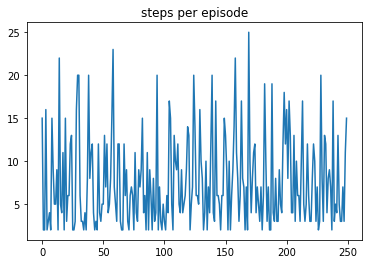


Average reward:  0.012
Last-50 avg reward:  0.0


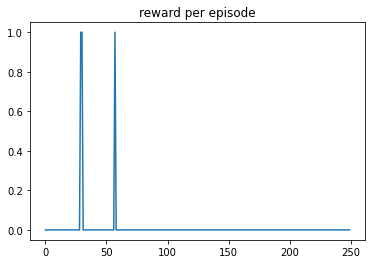

In [3]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 250
_GAMMA = 1  
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, render=False)

# Q-values
Q = torch.zeros((env._env.nS, env._env.nA))

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []

for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    
    done = False  # episode done?
    while not done:
        # select action with greatest Q-value for the current state
        # we have added some randomness because of the initial 0.0 values of the matrix
        # dim=1 calculates the maximum of each row (per columns)
        # max() returns two tensors: 
        #    [0]: tensor of maximum values per row (dim=1)
        #    [1]: tensor of column index (action) with maximum value of each row (dim=1)
        action = torch.max(Q + torch.randn(env._env.nA)/1E3, dim=1)[1][state].item()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        # we add the maximum Q-value of the new state
        Q[state, action] = reward + _GAMMA*torch.max(Q, dim=1)[0][new_state].item()
        
        # update state
        state = new_state
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)
        
# show Q-values
print("\n\nQ-values:\n")
print(f"{'LE':^7}{'DW':^7}{'RI':^7}{'UP':^7}")
print("-"*(7*Q.shape[1] - 1))
for r in range(Q.shape[0]):
    for c in range(Q.shape[1]):
        print(f"{Q[r,c]:6.3f} ",end="")
    print()
    if (r+1) % Q.shape[1] == 0:
        print("-"*(7*Q.shape[1] - 1))
        
# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))
print(f"Last-50 episodes solved: ", sum(episodes_solved[-50:]))
print(f"Last-50 avg episodes solved: ", sum(episodes_solved[-50:])/50)

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-50 avg steps: ", sum(episodes_steps[-50:])/50)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-50 avg reward: ", sum(episodes_rewards[-50:])/50)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

### 3. Temporal Difference Q learning
---
El problema con nuestra aproximación anterior es el siguiente. Mediante la ecuación de Bellman, **siempre** actualizamos el Q-valor de la pareja (s, a) en base al último resultado obtenido. Debido al comportamiento estocástico del entorno, acciones que deberían ser las idóneas para un determinado estado, podrían obtener un mal resultado y no ser seleccionadas en el futuro. De la tabla de _Q-values_ resultante, observamos que no hubo ningún aprendizaje.

En la aproximación de diferencia temporal, el proceso de aprendizaje tiene en cuenta tanto las observaciones futuras como las presentes. En concreto, se estima la **diferencia temporal** entre el _Q-value actual_ y el que obtendríamos al realizar la acción (**TD**):

<br>

![temp_diff.png](temp_diff.png)

<br>

Así, la actualización de los Q-values sería:

<br>

![q-learn_eq1.png](q-learn_eq1.png)

<br>

Donde **𝛼** es el **_learning rate_** que determina cuánto debe cambiar el modelo en base a dicha diferencia temporal (cambio en el _Q-value_).

Sustituyendo TD, obtendremos:

<br>

![q-learn_eq2.png](q-learn_eq2.png)

<br>

resultando en:

<br>

![q-learn_eq3.png](q-learn_eq3.png)

<br>

Observaremos que el comportamiento es mucho mejor que el de la aproximación determinista. Aún así, un entorno cambiante como éste supone un importante reto para el agente.

Por otro lado, el modelo es muy sensible al _tuning_ de los **hiperparámetros 𝛼** y **𝛾**, que deberemos ajustar manualmente por prueba y error.

IntProgress(value=0, description='Episodes [1000]:', max=1000, style=ProgressStyle(bar_color='#44a0fd'))



Q-values:

  LE     DW     RI     UP   
---------------------------
 0.113  0.000  0.000  0.000 
 0.008  0.000  0.000  0.000 
 0.052  0.000  0.002  0.000 
 0.001  0.000  0.000  0.003 
---------------------------
 0.116  0.000  0.002  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.059  0.001 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.114 
 0.000  0.210  0.000  0.000 
 0.541  0.001  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
 0.001  0.000  0.209  0.002 
 0.000  0.771  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------

Episodes solved:  402
Average episodes solved:  0.402
Last-100 episodes solved:  72
Last-100 avg episodes solved:  0.72

Average steps:  28.475
Last-100 avg steps:  37.73


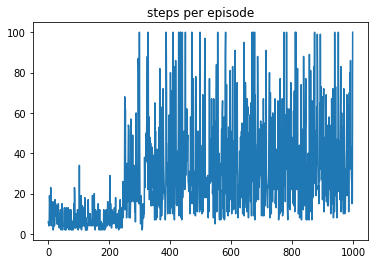


Average reward:  0.402
Last-100 avg reward:  0.72


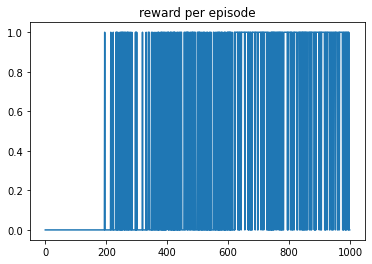

In [5]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 1000
_GAMMA = 0.95 
_ALPHA = 0.75 # learning rate
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, render=False)

# Q-values
Q = torch.zeros((env._env.nS, env._env.nA))

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []

for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
        
    done = False  # episode done?
    while not done:
        # select action with greatest Q-value for the current state
        # we have added some randomness because of the initial 0.0 values of the matrix
        # dim=1 calculates the maximum of each row (per columns)
        # max() returns two tensors: 
        #    [0]: tensor of maximum values per row (dim=1)
        #    [1]: tensor of column index (action) with maximum value of each row (dim=1)
        action = torch.max(Q + torch.randn(env._env.nA)/1E3, dim=1)[1][state].item()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        # we add the maximum Q-value of the new state
        Q[state, action] = (1 - _ALPHA)*Q[state, action] + \
                            _ALPHA * (reward + _GAMMA*torch.max(Q, dim=1)[0][new_state].item())
        
        # update state
        state = new_state
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)
        
# show Q-values
print("\n\nQ-values:\n")
print(f"{'LE':^7}{'DW':^7}{'RI':^7}{'UP':^7}")
print("-"*(7*Q.shape[1] - 1))
for r in range(Q.shape[0]):
    for c in range(Q.shape[1]):
        print(f"{Q[r,c]:6.3f} ",end="")
    print()
    if (r+1) % Q.shape[1] == 0:
        print("-"*(7*Q.shape[1] - 1))
        
# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))
print(f"Last-100 episodes solved: ", sum(episodes_solved[-100:]))
print(f"Last-100 avg episodes solved: ", sum(episodes_solved[-100:])/100)

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-100 avg steps: ", sum(episodes_steps[-100:])/100)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-100 avg reward: ", sum(episodes_rewards[-100:])/100)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

### 4. Recompensa y Aprendizaje
---
Por último, vamos a ver como se comporta nuestro algoritmo cuando introducimos recompensas negativas al intentar salirse del tablero o al caer en los agujeros...

A efectos de comparación, iteraremos sobre el mismo número de episodios y mantendremos los mismos valores para los hiperparámetros **𝛼** y **𝛾** que en el caso anterior.

IntProgress(value=0, description='Episodes [1000]:', max=1000, style=ProgressStyle(bar_color='#44a0fd'))



Q-values:

  LE     DW     RI     UP   
---------------------------
-0.538 -0.547 -0.189 -0.571 
-0.266 -0.144 -0.255 -0.231 
-0.236 -0.171 -0.266 -0.250 
-0.218 -0.447 -0.397 -0.420 
---------------------------
-0.284 -0.286 -0.177 -0.260 
 0.000  0.000  0.000  0.000 
-0.200 -0.200 -0.090 -0.200 
 0.000  0.000  0.000  0.000 
---------------------------
-0.228 -0.259 -0.017 -0.264 
-0.179  0.235 -0.177 -0.185 
 0.162 -0.188 -0.188 -0.181 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
-0.264 -0.199 -0.202  0.835 
-0.100 -0.147  0.401 -0.120 
 0.000  0.000  0.000  0.000 
---------------------------

Episodes solved:  32
Average episodes solved:  0.032
Last-100 episodes solved:  4
Last-100 avg episodes solved:  0.04

Average steps:  6.466
Last-100 avg steps:  6.48


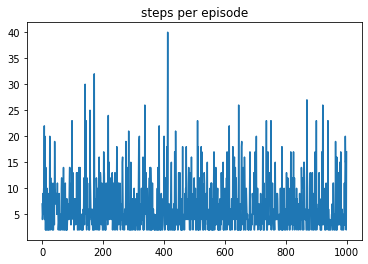


Average reward:  -0.2625999999999991
Last-100 avg reward:  -0.25899999999999984


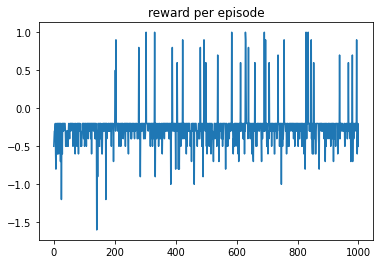

In [8]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 1000
_REWD_HOLE = -0.200 # fall into the hole reward
_REWD_WALL = -0.100 # stumble into the wall
_REWD_GOAL = 1000
_GAMMA = 0.95 # look ahead
_ALPHA = 0.75 # learning_rate
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, render=False)
env.rewd_hole = _REWD_HOLE
env.rewd_wall = _REWD_WALL
env.rewd_goal = _REWD_GOAL

# Q-values
Q = torch.zeros((env._env.nS, env._env.nA))

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []

for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    env.run_once()
        
    done = False  # episode done?
    while not done:
        # select action with greatest Q-value for the current state
        # we have add some randomness because of the initial 0.0 values of the matrix
        # dim=1 calculates the maximum of each row (per columns)
        # max() returns two tensors: 
        #    [0]: tensor of maximum values per row (dim=1)
        #    [1]: tensor of column index with maximum value of each row (dim=1)
        action = torch.max(Q + torch.randn(env._env.nA)/1E6, dim=1)[1][state].item()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        # we add the maximum Q-value of the new state
        Q[state, action] = (1 - _ALPHA)*Q[state, action] + \
                    _ALPHA * (reward + _GAMMA*torch.max(Q, dim=1)[0][new_state].item())
        
        # update state
        state = new_state
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
        # update window
        env.run_once()
    
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)
        
# show Q-values
print("\n\nQ-values:\n")
print(f"{'LE':^7}{'DW':^7}{'RI':^7}{'UP':^7}")
print("-"*(7*Q.shape[1] - 1))
for r in range(Q.shape[0]):
    for c in range(Q.shape[1]):
        print(f"{Q[r,c]:6.3f} ",end="")
    print()
    if (r+1) % Q.shape[1] == 0:
        print("-"*(7*Q.shape[1] - 1))
        
# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))
print(f"Last-100 episodes solved: ", sum(episodes_solved[-100:]))
print(f"Last-100 avg episodes solved: ", sum(episodes_solved[-100:])/100)

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-100 avg steps: ", sum(episodes_steps[-100:])/100)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-100 avg reward: ", sum(episodes_rewards[-100:])/100)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

### 5. Almacenando el modelo
---
  
<br>

##### 5.1. El modelo
---
Nuestro nuevo agente incluirá el hiperparámetro **epsilon** que nos permitirá definir la probabilidad de realizar una acción aleatoria en lugar de la acción de más valor para el estado actual (ε-greedy algorithm).

Ahora, el agente recibe un referencia al entorno, en lugar del número de estados y de acciones

In [6]:
import torch
import numpy as np

class FrozenLakeAgent_QL():
    """Agent class for deterministic/stochastic FrozenLake environment.
    
        For deterministic environment, gamma and alpha should be 1.0
        Epsilon (>= 0) defines the probability of a random action
        Epsilon_End and Epsilon_Decay controls the adaptative Epsilon greedy: 
        - eps_end is the final epsilon value
        - eps_dec is the decreasing factor per step
    """
    def __init__(self, env, train=False, gamma=1.0, alpha=1.0, eps=0.0, eps_end=0.0, eps_dec=1.0):
        self._env = env
        self._nA = env._env.nA
        self._nS = env._env.nS
        self._train = train
        self._gamma = gamma
        self._alpha = alpha
        self._eps = eps
        self._eps_end = eps_end
        self._eps_dec = eps_dec
        self._state = 0
        self._Q = torch.zeros((self._env.nS, self._env.nA))
        
    def reset(self, state):
        self._state = state
        
    def get_action(self):
        action = None
        
        # exploitation vs exploration
        if self._train and torch.rand(1).item() < self._eps:
            action = self._env.action_space.sample() # exploration (random move)
        else: 
            action = torch.max(self._Q + torch.randn(self._nA)/1E3, dim=1)[1][self._state].item()
        
        # update epsilon
        if self._train and self._eps > self._eps_end:
            self._eps *= self._eps_dec       

        return action
        
    def update(self, new_state, r, action):
        if self._train:
            # update Q-value
            self._Q[self._state, action] = (1 - self._alpha) * self._Q[self._state, action] + \
                    self._alpha * (r + self._gamma*torch.max(self._Q, dim=1)[0][new_state].item())
        self._state = new_state
        
    def load_model(self, file_name):
        nQ = np.loadtxt(file_name, dtype=np.float32, delimiter=";")
        self._Q = torch.from_numpy(nQ)
        
    def save_model(self, file_name):
        np.savetxt(file_name, self._Q.detach().cpu().numpy(), delimiter=";")
        
    def print_model(self):
        # show Q-values
        print("\n\nQ-values:\n")
        print(f"{'LE':^7}{'DW':^7}{'RI':^7}{'UP':^7}")
        print("-" * (7 * self._Q.shape[1] - 1))        
        for r in range(self._Q.shape[0]):
            for c in range(self._Q.shape[1]):
                print(f"{self._Q[r,c]:6.3f} ",end="")
            print()
            if (r+1) % self._Q.shape[1] == 0:
                print("-" * (7 * self._Q.shape[1] - 1))


<br>

##### 5.2. Entrenando el modelo
---
A la hora de crear el modelo, podemos establecer los parámetros **gamma** y **alpha** (deben ser 1.0 en caso de un entorno determinista)

IntProgress(value=0, description='Episodes [1000]:', max=1000, style=ProgressStyle(bar_color='#44a0fd'))



Q-values:

  LE     DW     RI     UP   
---------------------------
-0.555 -0.555 -0.176 -0.534 
-0.288 -0.194 -0.267 -0.284 
-0.252 -0.125 -0.237 -0.258 
-0.459 -0.117 -0.475 -0.499 
---------------------------
-0.238 -0.255 -0.182 -0.257 
 0.000  0.000  0.000  0.000 
-0.198 -0.200 -0.078 -0.200 
 0.000  0.000  0.000  0.000 
---------------------------
-0.219 -0.260 -0.197 -0.224 
-0.150  0.142 -0.150 -0.150 
 0.012 -0.150 -0.154 -0.177 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
-0.153 -0.215  0.237 -0.188 
 0.000  0.000  0.000  0.391 
 0.000  0.000  0.000  0.000 
---------------------------

Saving model... OK

Episodes solved:  43
Average episodes solved:  0.043
Last-100 episodes solved:  2
Last-100 avg episodes solved:  0.02

Average steps:  6.753
Last-100 avg steps:  7.26


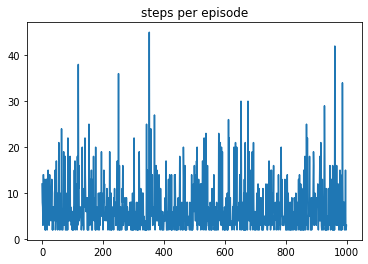


Average reward:  -0.25409999999999927
Last-100 avg reward:  -0.27599999999999986


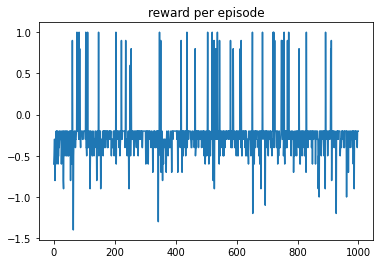

In [8]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import time
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 1000
_REWD_HOLE = -0.200 # fall into the hole reward
_REWD_WALL = -0.100 # stumble into the wall
_REWD_GOAL = 1000
_GAMMA = 0.95 # look ahead
_ALPHA = 0.75 # learning_rate
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, render=False)
env.rewd_hole = _REWD_HOLE
env.rewd_wall = _REWD_WALL
env.rewd_goal = _REWD_GOAL

# Agent
agent = FrozenLakeAgent_QL(env, train=True, gamma=_GAMMA, alpha=_ALPHA)

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []

for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    agent.reset(state)
    env.run_once()
    
    done = False  # episode done?
    while not done:
        # get action
        action = agent.get_action()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        agent.update(new_state, reward, action)
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
        # update window
        env.run_once()

    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)        
        
# print model
agent.print_model()

# save model
print("\nSaving model... ", end="")
agent.save_model("frozenlake_QL_model.csv")
print("OK")

# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))
print(f"Last-100 episodes solved: ", sum(episodes_solved[-100:]))
print(f"Last-100 avg episodes solved: ", sum(episodes_solved[-100:])/100)

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-100 avg steps: ", sum(episodes_steps[-100:])/100)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-100 avg reward: ", sum(episodes_rewards[-100:])/100)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()


##### 5.3. Probando el modelo
---

In [9]:
# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 10
# ---------------------------------------------------------------------------------

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, sound=True)

env.set_im_goal('art/batt.png')

env.hole_color = (25, 25, 25)
env.grid_color = (220, 220, 255)
env.home_color = (200, 255, 200)
env.goal_color = (255, 200, 200)

# Agent
agent = FrozenLakeAgent_QL(env)

# load model
print("Cargando el modelo... ", end="")
agent.load_model("frozenlake_QL_model.csv")
print("OK")

for i in range(_EPISODES):
    print(f"\nEpisode: {i+1}... ", end="")
    
    # initial state
    state = env.reset() 
    agent.reset(state)
    
    env.run_once()
    time.sleep(1)
    
    done = False  # episode done?
    while env.is_alive and not done:
        # perform action
        new_state, reward, done, _ = env.step(agent.get_action())
        
        # update agent state
        agent.update(new_state, reward, action)
        
        # update window
        env.run_once()
        time.sleep(0.25)
    
    if env.goal: print("goal! ", end="")
    print("(episode done)")
    time.sleep(1)
    
    if not env.is_alive:
        break

# wait until window closes
while env.is_alive:
    env.run_once()

Cargando el modelo... OK

Episode: 1... (episode done)

Episode: 2... (episode done)

Episode: 3... (episode done)

Episode: 4... (episode done)

Episode: 5... (episode done)

Episode: 6... (episode done)

Episode: 7... (episode done)

Episode: 8... (episode done)

Episode: 9... (episode done)

Episode: 10... (episode done)
